In [15]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
import re
import os

from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt

sys.path.append('../')
from stark import utils

In [16]:
def read_spectrum(file, specpath = '../data/raw/sp'):
    # find, download, or skip the file
    path = os.path.join(specpath, file)
    table = ascii.read(path)
    wl = utils.air2vac(table['Table'].data)
    fl = table[':'].data
    mask = (5260 < wl) * (wl < 5280) # continuum region
    snr = np.nanmean(fl[mask]) / np.nanstd(fl[mask])
    snr = snr if ~np.isnan(snr) else 1
    ivar =  snr**2 / (table[':'].data + 1e-6)**2
    return wl, fl, ivar


In [17]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [18]:
from stark import measurestark as ms
lines_to_run = ['abgd', 'ab', 'a', 'b', 'g', 'd']
#lines_to_run = ['g', 'd']
#windows = [9,8,7,6,5,4,3,2,1,0]
windows = [9,8]
names = pd.read_csv('../data/processed/good_spy.csv').FileName.values

for lines in lines_to_run:
    print(f'lines: {lines}')
    for i in windows:
        print(f'windows: {i}')
        try:
            alldata = pd.read_csv(f'../../data/processed/1d_nlte_15a/{lines}/window_{i}.csv')
        except:
            alldata = pd.DataFrame({'filename' : [], 'lte_rv' : [], 'lte_e_rv' : [], 'lte_teff' : [], 'lte_logg' : [], 'lte_redchi' : [],})
                    #'nlte_rv' : [], 'nlte_e_rv' : [], 'nlte_teff' : [], 'nlte_logg' : [], 'nlte_redchi' : [],
                    #'vstark' : [], 'e_vstark' : []})

        unique_names = list(set(names) - set(alldata.filename))
        for name in tqdm(unique_names):
            #try:
            wavl, flux, ivar = read_spectrum(name)
            #plt.plot(wavl, flux)
            with suppress_stdout():
                dat, lte_fig = ms.measure_spectrum(wavl, flux, ivar, i, lines = lines, lte_mask_size = 8, nlte_core_size = 15, modeltype='1d_da_nlte')
                dat = pd.DataFrame(dat)
                #dat = pd.DataFrame(ms.measure_spectrum(wavl, flux, ivar, i, lines = lines, lte_mask_size = 8, nlte_core_size = 8, modeltype='1d_da_nlte'))
            dat['filename'] = name

            alldata = pd.concat([alldata, dat])
            alldata.to_csv(f'../data/processed/lte/15angstrom/{lines}/window_{i}.csv', index=False)
            #except:
            #    print(f'Fit failed: {name}')
            
        if (lines != 'abgd') and (i <= 8):
            break

lines: abgd
windows: 9


  0%|          | 4/1184 [00:54<4:19:46, 13.21s/it]/home/arsen/miniconda3/envs/stark/lib/python3.12/site-packages/corv/fit.py:149: RuntimeWarning: invalid value encountered in sqrt
  intersect = ( (-pcoef[1] + np.sqrt(pcoef[1]**2 - 4 * pcoef[0] * (pcoef[2] - t_cc - 1))) / (2 * pcoef[0]),
/home/arsen/miniconda3/envs/stark/lib/python3.12/site-packages/corv/fit.py:150: RuntimeWarning: invalid value encountered in sqrt
  (-pcoef[1] - np.sqrt(pcoef[1]**2 - 4 * pcoef[0] * (pcoef[2] - t_cc - 1))) / (2 * pcoef[0]) )
  1%|          | 9/1184 [02:07<4:32:59, 13.94s/it]/home/arsen/miniconda3/envs/stark/lib/python3.12/site-packages/corv/fit.py:149: RuntimeWarning: invalid value encountered in sqrt
  intersect = ( (-pcoef[1] + np.sqrt(pcoef[1]**2 - 4 * pcoef[0] * (pcoef[2] - t_cc - 1))) / (2 * pcoef[0]),
/home/arsen/miniconda3/envs/stark/lib/python3.12/site-packages/corv/fit.py:150: RuntimeWarning: invalid value encountered in sqrt
  (-pcoef[1] - np.sqrt(pcoef[1]**2 - 4 * pcoef[0] * (pcoef[2] - t_cc 

TypeError: expected non-empty vector for x

In [6]:
import corv
import matplotlib.pyplot as plt

model = corv.models.Spectrum('1d_da_nlte')

def forward(teff, logg, snr):
    wavl, interp = model.wavl, model.model_spec
    flux = interp((teff, logg))
    ivar = (snr / flux)**2

    wavl_new = np.arange(3000, 9000, 0.2)
    flux_new = np.interp(wavl_new, wavl, flux)
    ivar_new = np.interp(wavl_new, wavl, ivar)

    flux_new += np.random.normal(loc=0, scale=flux_new/snr)
    return wavl_new, flux_new, ivar_new


RuntimeError: No active exception to reraise

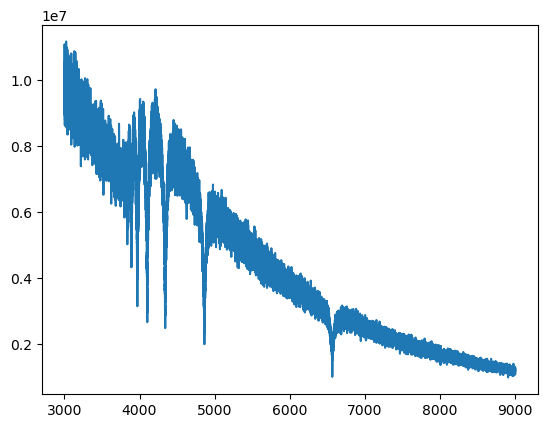

In [ ]:
wavl, flux, ivar = forward(10000, 8, 20)
plt.plot(wavl, flux)
raise

In [ ]:
from stark import measurestark as ms
lines_to_run = ['abgd']
windows = [9,8,7,6,5,4,3,2,1,0]
n_to_run = 300

for lines in lines_to_run:
    print(f'lines: {lines}')
    for i in windows:
        print(f'windows: {i}')
        try:
            alldata = pd.read_csv(f'../../data/processed/comparison/1d_nlte/{lines}/window_{i}.csv')
        except:
            alldata = pd.DataFrame({'filename' : [], 'lte_rv' : [], 'lte_e_rv' : [], 'lte_teff' : [], 'lte_logg' : [], 'lte_redchi' : [],
                    'nlte_rv' : [], 'nlte_e_rv' : [], 'nlte_teff' : [], 'nlte_logg' : [], 'nlte_redchi' : [],
                    'vstark' : [], 'e_vstark' : []})
            
        n = n_to_run - len(alldata)
        n = 0 if n < 0 else n
        for _ in tqdm(range(n)):
            try:
                theta = np.random.uniform(low=[4000, 7.1], high=[25000, 8.9], size=(1, 2))[0]
                wavl, flux, ivar = forward(theta[0], theta[1], 35)
                with suppress_stdout():
                    dat = pd.DataFrame(ms.measure_spectrum(wavl, flux, ivar, i, lines = lines, lte_mask_size = 8, nlte_core_size = 15, modeltype='1d_da_nlte'))
                dat['real_teff'] = theta[0]
                dat['real_logg'] = theta[1]
                dat['snr'] = 50

                alldata = pd.concat([alldata, dat])
                alldata.to_csv(f'../../data/processed/comparison/1d_nlte/{lines}/window_{i}.csv', index=False)
            except:
                print(f'Fit failed!')
            
        if lines != 'abgd':
            break

lines: abgd
windows: 9


0it [00:00, ?it/s]

windows: 8



0it [00:00, ?it/s]


windows: 7


0it [00:00, ?it/s]


windows: 6


0it [00:00, ?it/s]


windows: 5


0it [00:00, ?it/s]


windows: 4


0it [00:00, ?it/s]


windows: 3


0it [00:00, ?it/s]


windows: 2


0it [00:00, ?it/s]


windows: 1


0it [00:00, ?it/s]


windows: 0


  1%|          | 1/141 [00:05<13:21,  5.73s/it]

Fit failed!


  1%|▏         | 2/141 [00:11<13:31,  5.84s/it]

Fit failed!


  2%|▏         | 3/141 [00:18<14:19,  6.23s/it]

Fit failed!


  3%|▎         | 4/141 [00:21<11:14,  4.93s/it]

Fit failed!


  4%|▎         | 5/141 [00:28<13:13,  5.83s/it]

Fit failed!
